# <center> 作业三 All-Dogs </center>
by Hyr1sky_He

_为了提高任务效率，本ipynb中不再细化每个步骤的操作过程，仅记录重要思路及核心方法，Task题目解答将在实验报告中给出_

In [2]:
import numpy as np
import pandas as pd
import torch
import time
import os
import cv2
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from torchvision.utils import save_image
from torchvision.datasets import DatasetFolder, ImageFolder
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Constant
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
WEIGHT_DECAY = 1e-4

20579
(500, 375)


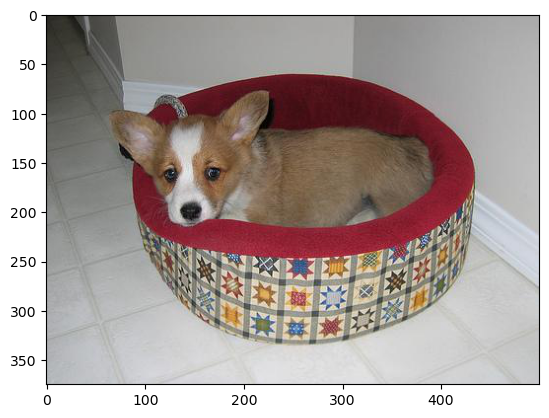

In [4]:
# Load data
root = '../Assignment3_dataset/all-dogs/'
all_images = os.listdir(root)
print(len(all_images))

idx = np.random.randint(0, len(all_images))
sample_img = Image.open(root + all_images[idx])
plt.imshow(sample_img)
print(sample_img.size)

In [5]:
# define a DataLoader
class UnsupervisedImageDataset(data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = os.listdir(root)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

322


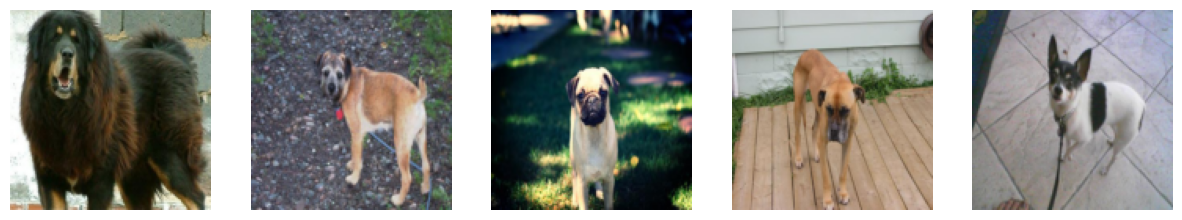

In [6]:
train_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_set = UnsupervisedImageDataset(root, train_tfm)
Train_Loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
print(len(Train_Loader))

# randomly show 5 images in a row
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(0, len(train_set))
    sample_img = train_set[idx]
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_img.permute(1, 2, 0))
    plt.axis('off')

In [7]:
# Create a mini-dataloader for testing
MINI_BATCH_SIZE = 16
MINISIZE = 1000
random_idx = np.random.randint(0, len(train_set), MINISIZE)
mini_set = data.Subset(train_set, random_idx)
mini_set.indices = np.arange(MINISIZE)
mini_loader = data.DataLoader(mini_set, batch_size=MINI_BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
print(len(mini_loader.dataset))
print(len(mini_loader))

1000
62


In [8]:
"""
About Conv2d:
    in_channels (int) - Number of channels in the input image
    out_channels (int) - Number of channels produced by the convolution
    kernel_size (int or tuple) - Size of the convolving kernel
    stride (int or tuple, optional) - Stride of the convolution. Default: 1
    padding (int or tuple, optional) - Zero-padding added to both sides of the input. Default: 0
    dilation (int or tuple, optional) - Spacing between kernel elements. Default: 1
    groups (int, optional) - Number of blocked connections from input channels to output channels. Default: 1
    bias (bool, optional) - If True, adds a learnable bias to the output. Default: True

    input: (N, C_in, H_in, W_in)
    N: batch size
    C_in: channel of input image
    H_in: height of input image
    W_in: width of input image
"""

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        # [3, 128, 128] -> [16, 8, 8]
        self.encoder = nn.Sequential(
            # N, 3, 128, 128
            nn.Conv2d(3, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(192, 96, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(96, 16, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
        )

        # Decoder
        # [16, 8, 8] -> [3, 128, 128]
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 96, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(96, 192, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(192, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(96, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

        # Fully connected 
        """
        self.fc1 = nn.Sequential(
            nn.Linear(16*8*8, 128),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 16*8*8),
            nn.BatchNorm1d(16*8*8),
            nn.ReLU(),
        )
        """

    def forward(self, x):
        # return indices
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_latent_code(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)  # Flatten the output

    def generate_from_latent_code(self, x):
        # Reshape the latent code
        x = x.view(x.size(0), 16, 8, 8)
        x = self.decoder(x)
        return x
    
"""
model = AutoEncoder()
sample_input = torch.rand((1, 3, 128, 128))
latend_code = model.get_latent_code(sample_input)
print(latend_code.shape)  # suppose output torch.Size([1, 16, 8, 8])
output = model(sample_input)
print(output.shape)  # suppose output torch.Size([1, 3, 128, 128])
"""

'\nmodel = AutoEncoder()\nsample_input = torch.rand((1, 3, 128, 128))\nlatend_code = model.get_latent_code(sample_input)\nprint(latend_code.shape)  # suppose output torch.Size([1, 16, 8, 8])\noutput = model(sample_input)\nprint(output.shape)  # suppose output torch.Size([1, 3, 128, 128])\n'

In [3]:
"""
About Conv2d:
    in_channels (int) - Number of channels in the input image
    out_channels (int) - Number of channels produced by the convolution
    kernel_size (int or tuple) - Size of the convolving kernel
    stride (int or tuple, optional) - Stride of the convolution. Default: 1
    padding (int or tuple, optional) - Zero-padding added to both sides of the input. Default: 0
    dilation (int or tuple, optional) - Spacing between kernel elements. Default: 1
    groups (int, optional) - Number of blocked connections from input channels to output channels. Default: 1
    bias (bool, optional) - If True, adds a learnable bias to the output. Default: True

    input: (N, C_in, H_in, W_in)
    N: batch size
    C_in: channel of input image
    H_in: height of input image
    W_in: width of input image
"""

class AutoEncoderOrigin(nn.Module):
    def __init__(self):
        super(AutoEncoderOrigin, self).__init__()

        # Encoder
        # [3, 128, 128] -> [16, 8, 8]
        self.encoder = nn.Sequential(
            # N, 3, 128, 128
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1), # N, 8, 64, 64
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False), # N, 6, 32, 32
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 16, 16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False), # N, 16, 8, 8
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        # Decoder
        # [16, 8, 8] -> [3, 128, 128]
        self.decoder = nn.Sequential(
            # N, 16, 8, 8
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 8, 16, 16
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # nn.MaxUnpool2d(kernel_size=2, stride=2), # N, 8, 32, 32
            # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 3, 64, 64
            nn.BatchNorm2d(3),
            nn.ReLU(),
            # nn.MaxUnpool2d(kernel_size=2, stride=2), # N, 3, 128, 128
            # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 3, 128, 128
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 3, 128, 128
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )

        # Fully connected 
        """
        self.fc1 = nn.Sequential(
            nn.Linear(16*8*8, 128),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 16*8*8),
            nn.BatchNorm1d(16*8*8),
            nn.ReLU(),
        )
        """

    def forward(self, x):
        # return indices
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_latent_code(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)  # Flatten the output

    def generate_from_latent_code(self, x):
        # Reshape the latent code
        x = x.view(x.size(0), 16, 8, 8)
        x = self.decoder(x)
        return x
    
""""""
model = AutoEncoderOrigin()
sample_input = torch.rand((1, 3, 128, 128))
latend_code = model.get_latent_code(sample_input)
print(latend_code.shape)  # suppose output torch.Size([1, 16, 8, 8])
output = model(sample_input)
print(output.shape)  # suppose output torch.Size([1, 3, 128, 128])


torch.Size([1, 1024])
torch.Size([1, 3, 128, 128])


In [ ]:
# Normal Version
class AutoEncoderNormal(nn.Module):
    def __init__(self):
        super(AutoEncoderNormal, self).__init__()

        # Encoder
        # [3, 128, 128] -> [16, 8, 8]
        self.encoder = nn.Sequential(
            # N, 3, 128, 128
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1), # N, 8, 64, 64
            # nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False), # N, 6, 32, 32
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 16, 16
            # nn.BatchNorm2d(9),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False), # N, 16, 8, 8
            
            # nn.Conv2d(in_channels=9, out_channels=12, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(12),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(16),
            # nn.ReLU(),
        )

        # Decoder
        # [16, 8, 8] -> [3, 128, 128]
        self.decoder = nn.Sequential(
            # N, 16, 8, 8
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 8, 16, 16
            # nn.BatchNorm2d(12),
            nn.ReLU(),
            # nn.MaxUnpool2d(kernel_size=2, stride=2), # N, 8, 32, 32
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 3, 64, 64
            # nn.BatchNorm2d(9),
            nn.ReLU(),
            # nn.MaxUnpool2d(kernel_size=2, stride=2), # N, 3, 128, 128
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            
            # nn.ConvTranspose2d(in_channels=9, out_channels=6, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 3, 128, 128
            # nn.BatchNorm2d(6),
            # nn.ReLU(),
            # nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 3, 128, 128
            # nn.BatchNorm2d(3),
            nn.Tanh(),
        )

        # Fully connected 
        """
        self.fc1 = nn.Sequential(
            nn.Linear(16*8*8, 128),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 16*8*8),
            nn.BatchNorm1d(16*8*8),
            nn.ReLU(),
        )
        """

    def forward(self, x):
        # return indices
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_latent_code(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)  # Flatten the output

    def generate_from_latent_code(self, x):
        # Reshape the latent code
        x = x.view(x.size(0), 16, 8, 8)
        x = self.decoder(x)
        return x

In [9]:
# Train
class Trainer:
    def __init__(self, model):
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        self.criterion = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train(self, train_loader, epochs):
        # Set up the Directory
        if not os.path.exists('./params'):
            os.mkdir('./params')
        if not os.path.exists('./img/All_Dogs'):
            os.mkdir('./img/All_Dogs')

        # Print model
        print(self.model)
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            start = time.time()

            for batch_idx, data in enumerate(train_loader):
                img = data.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(img)
                loss = self.criterion(output, img)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                
            end = time.time()
            print('Epoch: {} | Total loss: {:.6f} | Time: {:.2f}s'.format(epoch+1, total_loss, end-start))

            # Save the reconstructed images
            recon_img = output.cpu().data
            real_img = img.cpu().data
            recon_img_V = recon_img[0:5]
            real_img_V = real_img[0:5]
            All_IMG = torch.cat((real_img_V, recon_img_V), 0)
            save_image(All_IMG, './img/All_Dogs/Epoch_{}.png'.format(epoch+1), nrow=5)

        # Save model
        torch.save(self.model.state_dict(), './params/autoencoder.pth')
        print('Finished training, model saved!')

In [15]:
# Train
model = AutoEncoder().to(device)
trainer = Trainer(model)
# trainer.train(Train_Loader, EPOCHS)
trainer.train(mini_loader, EPOCHS)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(10, 6, kernel_

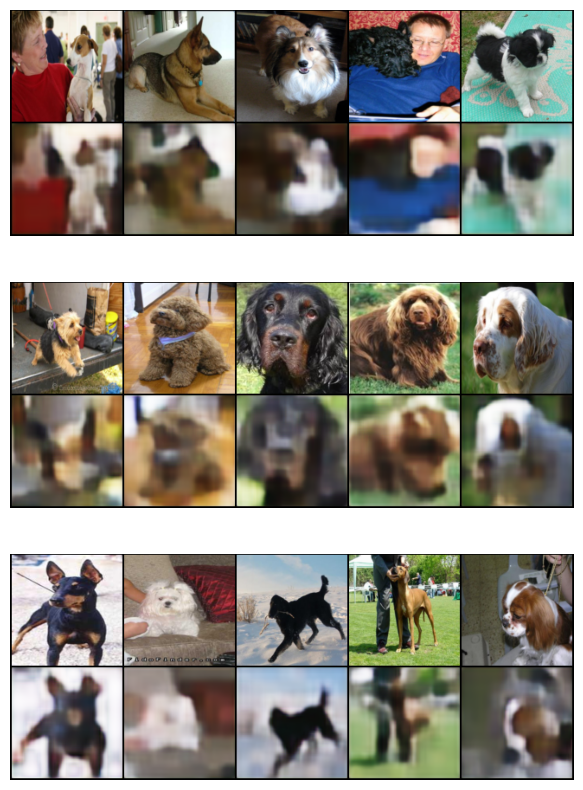

In [10]:
# Show the last 3 sets
plt.figure(figsize=(30, 10))
for i in range(3):
    sample_img = Image.open('./img/All_Dogs/Epoch_{}.png'.format(EPOCHS - 2 + i))
    plt.subplot(3, 1, i+1)
    plt.imshow(sample_img)
    # plt.imshow(sample_img.squeeze().permute(1, 2, 0).clip(0, 1))
    plt.axis('off')

# zip the images
import shutil
# shutil.make_archive('images', 'zip', './img/All_Dogs')

In [11]:
# Randomly Show 9 images
idx = np.random.randint(0, len(train_set), 9)
Random_Sample = data.Subset(train_set, idx)
Random_Loader = data.DataLoader(Random_Sample, batch_size=9, shuffle=False, num_workers=4)

for batch_idx, data in enumerate(Random_Loader):
    img = data.to(device)
    output = model(img)
    recon_img = output.cpu().data
    real_img = img.cpu().data
    Latent_Code = model.get_latent_code(img)
    print(Latent_Code.shape)
    All_IMG = torch.cat((real_img, recon_img), 0)
    print(All_IMG.shape)

# one row real_img -> latent_code -> recon_img
plt.figure(figsize=(30, 30))
for i in range(9):
    plt.subplot(9, 3, i * 3 + 1)
    plt.imshow(real_img[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(9, 3, i * 3 + 2)
    latent_code_flat = Latent_Code[i].squeeze().detach().cpu().numpy()
    latent_code_image = torch.reshape(torch.tensor(latent_code_flat), (32, 32)).detach().cpu().numpy()
    plt.imshow(latent_code_image)
    plt.axis('off')
    
    plt.subplot(9, 3, i * 3 + 3)
    plt.imshow(recon_img[i].permute(1, 2, 0))
    plt.axis('off')

    Contract = torch.cat((real_img[i], latent_code_image, recon_img[i]), 1)
    save_image(Contract, './img/All_Dogs/Contract_{}.png'.format(i+1), nrow=1)

plt.show()